# Building a Spam Filter with Naive Bayes

## Exploring The Dataset

In [1]:
import pandas as pd

sms_spam = pd.read_csv('SMS_spam.csv')

print(sms_spam.shape)
sms_spam.head()

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
sms_spam['Label'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

#### _We see that about 87% of the messages are ham(non-spam), and the remaining 13% are spam. This sample looks representative, since in practice most messages that people receive are ham._

# Training and Test DataFrame

We are going to split our dataset into a training and a test set, where the training set accounts for 80% of the data, and the test set for the remaining 20%.

In [3]:
# Randomize the dataset
data_randomized = sms_spam.sample(frac=1, random_state=1)

# Calculate index for split
training_test_index = round(len(data_randomized) * 0.8)

# Training/Test split
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


In [4]:
training_set['Label'].value_counts(normalize=True, dropna = False)

ham     0.864065
spam    0.135935
Name: Label, dtype: float64

In [5]:
test_set['Label'].value_counts(normalize = True, dropna = False)

ham     0.873429
spam    0.126571
Name: Label, dtype: float64

The results looks good, we will go ahead and clean the dataset.

# Data Cleaning

To calculate all the probabilities required by the algorithm, we'll first need to perform a bit of data cleaning to bring the data in a format that will allow us to extract easily all the information we need.

### Letter Case and Punctuation

We'll begin with removing all the punctuation and bringing every letter to lower case.

In [6]:
training_set.head()

,Label,SMS
0,ham,Convey my regards to him
1,ham,"[‰Û_] anyway, many good evenings to u! s"
2,ham,My sort code is and acc no is . The bank is n...
3,ham,Sorry i din lock my keypad.
4,spam,"Hi babe its Chloe, how r u? I was smashed on s..."


In [7]:
#Remove all punctuation marks
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ')

#Change all letters to small case
training_set['SMS'] = training_set['SMS'].str.lower()

/var/folders/_1/k282ft1s2txbg1374bmwt3v00000gn/T/ipykernel_9103/2111860875.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ')


In [8]:
training_set.head()

,Label,SMS
0,ham,convey my regards to him
1,ham,û_ anyway many good evenings to u s
2,ham,my sort code is and acc no is the bank is n...
3,ham,sorry i din lock my keypad
4,spam,hi babe its chloe how r u i was smashed on s...


## Creating the Vocabulary

Let's now move to creating the vocabulary, which in this context means a list with all the unique words in our training set.

In [9]:
#split the sms column on white space and convert each row to a list
training_set['SMS'] = training_set['SMS'].str.split()

vocabulary = []
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)

#Set returns tuple of unique words
vocabulary = list(set(vocabulary))

In [10]:
len(vocabulary)

7766

__There  are  7,783  unique  words in all the messages of our training set.__

## The Final Training Set

We're now going to use the vocabulary we just created to make the data transformation we want.

In [11]:
#Create a default dictionary with each unique word a count of zero
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

#Loop over the training set and count the number of times each unique word occurs
for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [12]:
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,depression,waliking,nightnight,blue,kaitlyn,dollars,6pm,playing,intha,insha,...,1,risk,parkin,image,konw,since,farting,gettin,09056242159,inviting
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
word_counts['fat'].value_counts(dropna = False)

0    4453
1       5
Name: fat, dtype: int64

In [14]:
word_counts['smth'].value_counts(dropna = False)

0    4448
1       9
2       1
Name: smth, dtype: int64

In [15]:
word_counts['the'].value_counts(dropna = False)

0     3658
1      625
2      133
3       30
4        9
10       1
5        1
8        1
Name: the, dtype: int64

In [16]:
word_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4458 entries, 0 to 4457
Columns: 7766 entries, depression to inviting
dtypes: int64(7766)
memory usage: 264.1 MB


In [17]:
training_set_clean = pd.concat([training_set, word_counts], axis=1)
training_set_clean.head()

,Label,SMS,depression,waliking,nightnight,blue,kaitlyn,dollars,6pm,playing,...,1,risk,parkin,image,konw,since,farting,gettin,09056242159,inviting
0,ham,"[convey, my, regards, to, him]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[û_, anyway, many, good, evenings, to, u, s]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[my, sort, code, is, and, acc, no, is, the, ba...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,"[sorry, i, din, lock, my, keypad]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,spam,"[hi, babe, its, chloe, how, r, u, i, was, smas...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculating Constants

We are now done with cleaning the training set, and we can begin creating the spam filter. The Naive Bayes algorithm will need to answer these two probability questions to be able to classify new messages:

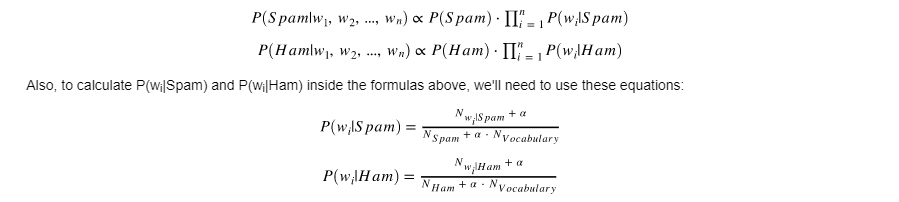

Some of the terms in the four equations above will have the same value for every new message. We can calculate the value of these terms once and avoid doing the computations again when a new messages comes in. Below, we will use our training set to calculate:

- P(Spam) and P(Ham)
- N$_{Spam}$, N$_{Ham}$, N$_{Vocabulary}$

We will also use Laplace smoothing and set $\alpha = 1$.

In [18]:
# Isolating spam and ham messages first
spam_messages = training_set_clean[training_set_clean['Label'] == 'spam']
ham_messages = training_set_clean[training_set_clean['Label'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(training_set_clean)
p_ham = len(ham_messages) / len(training_set_clean)

# N_Spam
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

# N_Ham
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

print('Probability of spam is: ' + str(round((p_spam * 100),2)) + '%' + '\n')
print('Probability of ham is: ' + str(round((p_ham * 100),2)) + '%' + '\n')
print('Number of spam messages is: ' + str(n_spam) + '\n')
print('Number of ham messages is: ' + str(n_ham) + '\n')
print('Number of unique words are: ' + str(p_spam))
#print(p_spam, p_ham, n_spam, n_ham, n_vocabulary)

Probability of spam is: 13.59%

Probability of ham is: 86.41%

Number of spam messages is: 15595

Number of ham messages is: 56168

Number of unique words are: 0.13593539703903096


## Calculating Parameters
Now that we have the constant terms calculated above, we can move on with calculating the parameters $P(w_i|Spam)$ and $P(w_i|Ham)$. Each parameter will thus be a conditional probability value associated with each word in the vocabulary.

The parameters are calculated using the formulas:

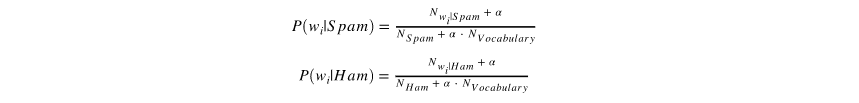

In [19]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

# Calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum()   # spam_messages already defined in a cell above
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + (alpha*n_vocabulary))
    parameters_spam[word] = p_word_given_spam
    
    n_word_given_ham = ham_messages[word].sum()   # ham_messages already defined in a cell above
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + (alpha*n_vocabulary))
    parameters_ham[word] = p_word_given_ham

Classifying A New Message
Now that we have all our parameters calculated, we can start creating the spam filter. The spam filter can be understood as a function that:

- Takes in as input a new message (w1, w2, ..., wn).
- Calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn).
- Compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn), and:
    - If P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn), then the message is classified as ham.
    - If P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn), then the message is classified as spam.
    - If P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn), then the algorithm may request human help.

In [20]:
import re

def classify(message):
    '''
    message: a string
    '''
    
    #remove all punctuations
    message = re.sub('\W', ' ', message)
    
    #lower and split all words on white space
    message = message.lower().split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
            
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)
    
    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [21]:
#Test the algorithm
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 7.551469020619691e-26
P(Ham|message): 3.13163390665657e-27
Label: Spam


In [22]:
classify('Good morning, are you on your way to work?')

P(Spam|message): 5.834120175907644e-28
P(Ham|message): 2.620334846163754e-22
Label: Ham


## Measuring the Spam Filter's Accuracy

The two results above look promising, but let's see how well the filter does on our test set, which has 1,114 messages.

We'll start by writing a function that returns classification labels instead of printing them.

In [23]:
def classify_test_set(message):    
    '''
    message: a string
    '''
    
    #remove all punctuations
    message = re.sub('\W', ' ', message)
    
    #lower and split all words on white space
    message = message.lower().split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
    
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

In [24]:
#Create a new column showing the result of our algorithm
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,S...from the training manual it show there is ...,ham
1,spam,Do you want a new Video phone? 600 anytime any...,spam
2,ham,True. Its easier with her here.,ham
3,ham,Midnight at the earliest,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [25]:
correct = 0
total = test_set.shape[0]
    
for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1
        
print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', str(correct/total * 100) + '%')

Correct: 1107
Incorrect: 7
Accuracy: 99.37163375224416%


The accuracy is close to $98.74$%, which is really good. Our spam filter looked at 1,114 messages that it hasn't seen in training, and classified 1,100 correctly.